In [1]:
import sys
sys.path.insert(0, '..')
from models_neural.quote_attribution.classification_models import SourceQA, SourceClassifier
import json
try:
    import attrdict
except:
    ! pip install attrdict
    import attrdict
from models_neural.src.config_helper import TransformersConfig
import pandas as pd 
import zipfile
from models_neural.quote_attribution.utils_dataset import SourceQADataModule, SourceClassificationDataModule
import torch
from tqdm.auto import tqdm

/job/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://artifactory.inf.bloomberg.com/artifactory/api/pypi/bloomberg-pypi/simple/, https://artifactory.inf.bloomberg.com/artifactory/api/pypi/python-dsp-wheels/simple


In [2]:
remote = True
if remote: 
    # download pretrained models/spacy 
    ! aws s3 cp --recursive s3://aspangher/spacy/en_core_web_lg/ en_core_web_lg/ --endpoint http://s3.dev.obdc.bcs.bloomberg.com
    ! aws s3 cp s3://aspangher/transformer-pretrained-models/roberta-base-expanded-embeddings.zip .  --endpoint http://s3.dev.obdc.bcs.bloomberg.com
    with zipfile.ZipFile('roberta-base-expanded-embeddings.zip', 'r') as zip_ref:
        zip_ref.extractall()

download: s3://aspangher/spacy/en_core_web_lg/meta.json to en_core_web_lg/meta.json   
download: s3://aspangher/spacy/en_core_web_lg/accuracy.json to en_core_web_lg/accuracy.json
download: s3://aspangher/spacy/en_core_web_lg/ner/cfg to en_core_web_lg/ner/cfg       
download: s3://aspangher/spacy/en_core_web_lg/ner/moves to en_core_web_lg/ner/moves  
download: s3://aspangher/spacy/en_core_web_lg/parser/moves to en_core_web_lg/parser/moves
download: s3://aspangher/spacy/en_core_web_lg/parser/cfg to en_core_web_lg/parser/cfg
download: s3://aspangher/spacy/en_core_web_lg/tagger/cfg to en_core_web_lg/tagger/cfg
download: s3://aspangher/spacy/en_core_web_lg/tagger/tag_map to en_core_web_lg/tagger/tag_map
download: s3://aspangher/spacy/en_core_web_lg/tokenizer to en_core_web_lg/tokenizer
download: s3://aspangher/spacy/en_core_web_lg/vocab/lookups_extra.bin to en_core_web_lg/vocab/lookups_extra.bin
download: s3://aspangher/spacy/en_core_web_lg/ner/model to en_core_web_lg/ner/model
download: s3

In [3]:
if remote:
    ! aws s3 cp s3://aspangher/source-exploration/data/our-annotated-data__stage-2.tsv  . --endpoint http://s3.dev.obdc.bcs.bloomberg.com
    data_fn = 'our-annotated-data__stage-2.tsv'
else:
    data_fn = '../models_neural/quote_attribution/data/our-annotated-data__stage-2.tsv'
data_df = pd.read_csv(data_fn, sep='\t', header=None)

download: s3://aspangher/source-exploration/data/our-annotated-data__stage-2.tsv to ./our-annotated-data__stage-2.tsv


In [4]:
uploaded_trained_models = ! aws s3 ls s3://aspangher/source-exploration/./ --endpoint http://s3.dev.obdc.bcs.bloomberg.com
uploaded_trained_models = list(map(lambda x: ' '.join(x.split()[3:]), uploaded_trained_models))

In [5]:
uploaded_trained_models

['config-Stage 2: Quote Attribution + Detection. Classification. Method 2. Our full dataset only. More unfrozen..json',
 'config-Stage 2: Quote Attribution + Detection. Classification. Method 2. Our full dataset only. No train on None..json',
 'config-Stage 2: Quote Attribution + Detection. Classification. Method 2. Our full dataset only..json',
 'config-Stage 2: Quote Attribution + Detection. Classification. Method 2. Sanity Check..json',
 'config-Stage 2: Quote Attribution + Detection. Classification. Our dataset only..json',
 'config-Stage 2: Quote Attribution + Detection. Classification. Token Expansion. Our full dataset only. No train on None..json',
 'config-Stage 2: Quote Attribution + Detection. Classification. Token Expansion. Our full dataset only..json',
 'config-Stage 2: Quote Attribution. Classification. Our dataset only..json',
 'config-Stage 2: Quote Attribution. Our dataset only..json',
 'trial-Stage 2: Quote Attribution + Detection. Classification. Method 2. Our full d

# Sanity Check Classification Model

In [6]:
remote = True
if remote:
    ! aws s3 cp s3://aspangher/source-exploration/data/quote-attribution-classification__sanity-check-data.tsv  . --endpoint http://s3.dev.obdc.bcs.bloomberg.com
    data_fn = 'quote-attribution-classification__sanity-check-data.tsv'
else:
    data_fn = '../models_neural/quote_attribution/data/quote-attribution-classification__sanity-check-data.tsv'
data_df = pd.read_csv(data_fn, sep='\t', header=None)

download: s3://aspangher/source-exploration/data/quote-attribution-classification__sanity-check-data.tsv to ./quote-attribution-classification__sanity-check-data.tsv


In [9]:
model_name = 'Stage 2: Quote Attribution + Detection. Classification. Method 2. Our full dataset only. No train on None'
model_name = 'Sanity Check'

In [10]:
paths = list(filter(lambda x: model_name in x, uploaded_trained_models))
model_path = list(filter(lambda x: 'trial-' in x, paths))[0]
config_path = list(filter(lambda x: 'config-' in x, paths))[0]

In [12]:
paths = list(filter(lambda x: model_name in x, uploaded_trained_models))
model_path = list(filter(lambda x: 'trial-' in x, paths))[0]
config_path = list(filter(lambda x: 'config-' in x, paths))[0]
if remote:
    # download config
    ! aws s3 cp "s3://aspangher/source-exploration/./$config_path"  . --endpoint http://s3.dev.obdc.bcs.bloomberg.com
                
    # download models
    ! aws s3 cp "s3://aspangher/source-exploration/./$model_path"  . --endpoint http://s3.dev.obdc.bcs.bloomberg.com

download: s3://aspangher/source-exploration/./config-Stage 2: Quote Attribution + Detection. Classification. Method 2. Sanity Check..json to ./config-Stage 2: Quote Attribution + Detection. Classification. Method 2. Sanity Check..json
download: s3://aspangher/source-exploration/./trial-Stage 2: Quote Attribution + Detection. Classification. Method 2. Sanity Check.__epoch=09-perplexity=0.00.ckpt to ./trial-Stage 2: Quote Attribution + Detection. Classification. Method 2. Sanity Check.__epoch=09-perplexity=0.00.ckpt


In [13]:
with open(config_path) as f:
    config_dict = json.load(f)

config_dict = attrdict.AttrDict(config_dict)
config_dict.pretrained_files_s3 = config_dict.pretrained_model_path
config_dict.model_type = 'roberta'

In [14]:
model = SourceClassifier.load_from_checkpoint(model_path, config=config_dict)
if remote:
    model = model.to('cuda')

../models_neural/src/layers_embeddings.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.default_max_pos = nn.Parameter(torch.tensor(self.max_position_embs - 1), requires_grad=False)


In [ ]:
config_dict.include_nones_as_positives = config_dict.train_on_none
data_model = SourceClassificationDataModule(
    config=config_dict,
    data_fp=data_fn,
    model_type='roberta',
    max_length_seq=2048,
    pretrained_model_path=config_dict.pretrained_model_path,
    batch_size=1,
    spacy_path='en_core_web_lg'
)

In [23]:
data_model.prepare_data()
data_model.setup()
dataloader = data_model.val_dataloader()

100%|██████████| 335/335 [08:16<00:00,  1.48s/it]


In [50]:
all_samples = []
for idx, sample in tqdm(enumerate(data_model.test_dataset), total=len(data_model.test_dataset)):
    sample = data_model.collate_fn([sample])

    with torch.no_grad():
        input_ids = sample['input_ids'].to('cuda')
        attention_mask=sample['attention_mask'].to('cuda')
        sentence_ids=sample['target_sentence_ids'].to('cuda')
        person_ids = sample['target_person_ids'].to('cuda')
        output = model.forward(input_ids=input_ids, attention_mask=attention_mask, target_sentence_ids=sentence_ids, target_person_ids=person_ids)
    
    sample['pred'] = float(output[1].to('cpu')[0][0])
    all_samples.append(sample)

100%|██████████| 1687/1687 [00:32<00:00, 52.66it/s]


In [53]:
all_samples_df = pd.DataFrame(all_samples)

In [67]:
output_df = (
    all_samples_df[['labels', 'pred']]
    .assign(labels=lambda df: df['labels'].apply(lambda x: float(x[0][0])))
    .assign(pred=lambda df: df['pred'].apply(expit))
)

In [69]:
from scipy.special import expit
from sklearn.metrics import roc_auc_score, f1_score

In [73]:
roc_auc_score(output_df['labels'], output_df['pred'])

0.6701040061199922

In [88]:
import numpy as np 

In [90]:
f1_scores = {}
for i in np.arange(0, 1, .001):
    f1_scores[i] = f1_score(output_df['labels'], output_df['pred'] > i)

In [95]:
%matplotlib inline

<AxesSubplot:>

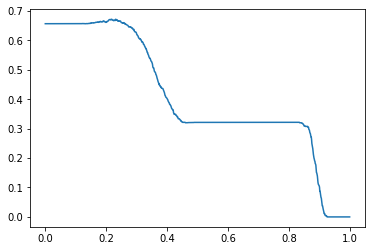

In [96]:
pd.Series(f1_scores).plot()

In [102]:
output_df['labels'].value_counts()

0.0    863
1.0    824
Name: labels, dtype: int64

In [101]:
f1_score(output_df['labels'], np.ones_like(output_df['labels']))

0.6563122262046993

In [105]:
all_samples_df.head(1)

,input_ids,target_sentence_ids,target_person_ids,labels,attention_mask,input_lens,pred
0,"[[tensor(0), tensor(15545), tensor(661), tenso...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...",[[tensor(1.)]],"[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[[tensor(14), tensor(6), tensor(9), tensor(12)...",-1.344397


In [128]:
all_samples_df['targeted_sentences'] = all_samples_df.apply(lambda x: x['input_ids'][0, (x['target_sentence_ids'] == 1).nonzero()[:, 1]], axis=1)

In [131]:
all_samples_df['decoded_sentences'] = all_samples_df['targeted_sentences'].apply(data_model.tokenizer.decode)

In [139]:
all_samples_df.pipe(lambda df: 
    f1_score(
        df['labels'].apply(lambda x: float(x[0][0])), 
        df['pred'] > 0
    )
)


0.3213610586011342

In [133]:
all_samples_df

,input_ids,target_sentence_ids,target_person_ids,labels,attention_mask,input_lens,pred,targeted_sentences,decoded_sentences
0,"[[tensor(0), tensor(15545), tensor(661), tenso...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...",[[tensor(1.)]],"[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[[tensor(14), tensor(6), tensor(9), tensor(12)...",-1.344397,"[tensor(0), tensor(113), tensor(19681), tensor...","<s>"" Tomorrow early morning first I go to morn..."
1,"[[tensor(0), tensor(15545), tensor(661), tenso...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...",[[tensor(0.)]],"[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[[tensor(17), tensor(16), tensor(8), tensor(17...",-0.979630,"[tensor(0), tensor(113), tensor(20), tensor(23...","<s>"" The train leaves every morning at 18 AM. ..."
2,"[[tensor(0), tensor(15545), tensor(661), tenso...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...",[[tensor(1.)]],"[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[[tensor(14), tensor(9), tensor(12), tensor(7)...",2.286806,"[tensor(0), tensor(113), tensor(4337), tensor(...","<s>"" Every child likes an ice cream. "" said au..."
3,"[[tensor(0), tensor(15545), tensor(661), tenso...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...",[[tensor(1.)]],"[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[[tensor(15), tensor(12), tensor(14), tensor(1...",-0.586940,"[tensor(0), tensor(113), tensor(38), tensor(65...","<s>"" I love my new pets. "" said Jenna Bellman</s>"
4,"[[tensor(0), tensor(15545), tensor(661), tenso...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...",[[tensor(0.)]],"[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[[tensor(18), tensor(8), tensor(14), tensor(12...",-1.132871,"[tensor(0), tensor(113), tensor(85), tensor(45...","<s>"" It snows a lot in winter in Russia. "" sai..."
...,...,...,...,...,...,...,...,...,...
1682,"[[tensor(0), tensor(15545), tensor(661), tenso...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...",[[tensor(1.)]],"[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[[tensor(15), tensor(17), tensor(12), tensor(1...",-0.386626,"[tensor(0), tensor(113), tensor(85), tensor(45...","<s>"" It snows a lot in winter in Russia. "" sai..."
1683,"[[tensor(0), tensor(15545), tensor(661), tenso...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...",[[tensor(1.)]],"[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[[tensor(13), tensor(10), tensor(8), tensor(15...",2.357715,"[tensor(0), tensor(113), tensor(1832), tensor(...","<s>"" Do you like spaghetti? "" said Jenna Bellm..."
1684,"[[tensor(0), tensor(15545), tensor(661), tenso...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...",[[tensor(0.)]],"[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[[tensor(13), tensor(13), tensor(16), tensor(8...",-1.554824,"[tensor(0), tensor(113), tensor(264), tensor(4...","<s>"" She does n’t use a computer. "" said autho..."
1685,"[[tensor(0), tensor(15545), tensor(661), tenso...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...",[[tensor(1.)]],"[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[[tensor(18), tensor(17), tensor(8), tensor(17...",-1.078834,"[tensor(0), tensor(113), tensor(1832), tensor(...","<s>"" Do you like spaghetti? "" said officials</s>"


# Classification Model

In [ ]:
model = 'config-Stage 2: Quote Attribution + Detection. Classification. Method 2. Our full dataset only. No train on None..json'

# QA Model

In [ ]:
qa_model_path = 'trial-Stage 2: Quote Attribution. Our dataset only.__epoch=05-perplexity=0.00.ckpt'
if remote:
    # download config
    ! aws s3 cp 's3://aspangher/source-exploration/./config-Stage 2: Quote Attribution. Our dataset only..json'  . --endpoint http://s3.dev.obdc.bcs.bloomberg.com
                
    # download models
    ! aws s3 cp "s3://aspangher/source-exploration/./$qa_model_path"  . --endpoint http://s3.dev.obdc.bcs.bloomberg.com

In [8]:
config_out = 'config-%s.json' % "Stage 2: Quote Attribution. Our dataset only."
with open(config_out) as f:
    config_dict = json.load(f)

config_dict = attrdict.AttrDict(config_dict)
config_dict.pretrained_files_s3 = config_dict.pretrained_model_path
config_dict.model_type = 'roberta'

In [9]:
model = SourceQA.load_from_checkpoint(model_path, config=config_dict)
if remote:
    model = model.to('cuda')

In [11]:
data_model = SourceQADataModule(
    config=config_dict,
    data_fp=data_fn,
    model_type='roberta',
    max_length_seq=2048,
    pretrained_model_path=config_dict.pretrained_model_path,
    batch_size=1,
    spacy_path='en_core_web_lg'
)

In [12]:
data_model.prepare_data()
data_model.setup()
dataloader = data_model.val_dataloader()

In [42]:
all_samples = []
for idx, sample in tqdm(enumerate(data_model.test_dataset), total=len(data_model.test_dataset)):
    sample = data_model.collate_fn([sample])

    with torch.no_grad():
        input_ids = sample['input_ids'].to('cuda')
        attention_mask=sample['attention_mask'].to('cuda')
        sentence_ids=sample['sentence_ids'].to('cuda')
        output = model.forward(input_ids=input_ids, attention_mask=attention_mask, sentence_ids=sentence_ids)

        start_logits, end_logits = output
        start, end = start_logits.argmax().to('cpu'), end_logits.argmax().to('cpu') 
    
    sample['pred_start'] = start
    sample['pred_end'] = end
    sample['start_logits'] = start_logits.to('cpu')
    sample['end_logits'] = end_logits.to('cpu')
    all_samples.append(sample)

100%|██████████| 712/712 [00:32<00:00, 22.18it/s]


In [92]:
samples_df = pd.DataFrame(all_samples)

In [96]:
# [['start_positions', 'end_positions', 'pred_start', 'pred_end']]
samples_df = (
    samples_df
        .assign(start_positions=lambda df: df['start_positions'].str.get(0).apply(int))
        .assign(end_positions=lambda df: df['end_positions'].str.get(0).apply(int)) 
        .assign(pred_start=lambda df: df['pred_start'].apply(int)) 
        .assign(pred_end=lambda df: df['pred_end'].apply(int)) 
)

In [115]:
samples_df = (samples_df
 .assign(true_span=lambda df: 
         df.apply(lambda x: x['input_ids'][:, x['start_positions']:x['end_positions']], axis=1)
           .apply(lambda x: data_model.tokenizer.decode(x[0]))
        )
 .assign(pred_span=lambda df: 
         df.apply(lambda x: x['input_ids'][:, x['pred_start']:x['pred_end']], axis=1)
           .apply(lambda x: data_model.tokenizer.decode(x[0]))
        )
)

In [123]:
t = samples_df[['true_span', 'pred_span']].applymap(lambda x: x.replace('</s><s>', ' '))

In [131]:
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

In [138]:
t.apply(lambda x: compute_f1(x['pred_span'], x['true_span']), axis=1).mean()

0.4470576309257075

In [139]:
t.apply(lambda x: compute_exact_match(x['pred_span'], x['true_span']), axis=1).mean()

0.43679775280898875

In [62]:
from sklearn.metrics import f1_score

In [87]:
start_end_df

,start_positions,end_positions,pred_start,pred_end
0,49,52,49,92
1,1387,1394,1387,22
2,1,3,27,335
3,235,239,240,239
4,277,279,157,159
...,...,...,...,...
707,363,365,857,365
708,635,640,1089,1093
709,97,101,97,101
710,614,618,295,777


In [ ]:
samples_df

In [65]:
start_end_df.pipe(lambda df: df['start_positions'] ==  df['pred_start']).mean()

0.5196629213483146

In [66]:
start_end_df.pipe(lambda df: df['end_positions'] ==  df['pred_end']).mean()

0.5084269662921348

In [84]:
def evaluate_overlap(row):
    temp_pred_start, temp_pred_end = row[['pred_start', 'pred_end']]
    pred_start = min(temp_pred_start, temp_pred_end)
    pred_end = max(temp_pred_start, temp_pred_end)
    
    true_start = row['start_positions']
    true_end = row['end_positions']
    
    start_mark = max(pred_start, true_start)
    end_mark = min(pred_end, true_end)
    
    num = max(0, end_mark - start_mark)
    denom = pred_end - pred_start
    
    return num / denom

In [86]:
start_end_df.apply(evaluate_overlap, axis=1).mean()

0.43925877688822845

In [115]:
from transformers import AutoTokenizer

In [117]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base-expanded-embeddings')

In [119]:
tokenizer.decode(sample['input_ids'][:, start:end][0])

' David W. Eaton'

In [136]:
start.to('cpu')

tensor(212)

In [123]:
end

tensor(216)

In [121]:
sample

{'start_positions': tensor([212]),
 'end_positions': tensor([216]),
 'input_ids': tensor([[    0, 15545,   661, 18718,   111,  2236,    96,     5,  2625,    81,
          25752,     9,   681,     8,  1123, 12252,  2156,  4257,   747, 22884,
              5,   810,    14,     5,   609,    64,   278,   160,  3027, 20396,
            479,     2,     0,  1708,  4211,   224,    14,    11,     5,   315,
            532,  2156, 25752,   111, 26914, 20396,    32,    45,  1537,   479,
              2,     0,  1121,   896,  2156,   959,  2156,    10, 22040,     9,
          20396,    11,  6055,   624,     5,   375,   292,   107,    34,    57,
           9702,     7, 25752,  2156,    50, 29215, 34905,  2156,    11,    61,
            514,  2156,  8321,     8,  6255,    32, 22993,    23,   239,  1164,
             88,    10,   157, 20463,    11,    10, 14352,  9285,     7,  1108,
             62,     5,  3152,     8,   800,   681,     8,  1123,   479,     2,
              0,  5975,  2156,  4211,  